# Code for generating Figure 3 and SFig 2 panels from derivative data

#### Raw code for generating derivative data is in analysis1_compute_regional_RDMs.py (using default parameters for main text figures)

`python analysis1_compute_regional_RDMs.py`

Note that raw code is intended for use on a local Yale cluster, but is included in this repository for completeness

In [1]:
import numpy as np
import nibabel as nib
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from importlib import reload
import wbplot
import pandas as pd
import matplotlib.image as img 
import os
import h5py
import matplotlib.colors as clrs
from matplotlib import colorbar
plt.rcParams['font.sans-serif'] = "Arial"
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
sns.set_style("ticks")
import networkx as nx
import bct
import sklearn

from brainsmash.mapgen.base import Base
from brainsmash.mapgen.stats import pearsonr, pairwise_r
from brainsmash.mapgen.stats import nonparp

#### Set up basic parameters

In [2]:
figuredir = '../figures/Fig3/'
if not os.path.exists(figuredir): os.makedirs(figuredir)

networkdef = np.loadtxt('cortex_parcel_network_assignments.txt')
# need to subtract one to make it compatible for python indices
indsort = np.loadtxt('cortex_community_order.txt',dtype=int) - 1 
indsort.shape = (len(indsort),1)

# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[indsort]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360

sortednets = np.sort(list(xticks.keys()))
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)
parcel_network_palette = []
for roi in range(nParcels): parcel_network_palette.append(networkpalette[int(networkdef[roi]-1)])

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

glasserfilename = 'Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser = np.squeeze(nib.load(glasserfilename).get_fdata())

#### split up sensorimotor from association network color palettes
color1, color2 = sns.color_palette(palette='Pastel1')[1], sns.color_palette(palette='Pastel1')[0]
associationnets = ['con','dan','lan','fpn','dmn','pmulti','none1','none2']
sensorimotornets = ['vis1','vis2','smn','aud']

roi_id = np.zeros((nParcels,))
tmp = {}
netcount = 0
for network in networkmappings:
    net = np.where(networkdef==networkmappings[network])[0]
    for roi in net:
        if network in associationnets:
            tmp[roi] = color1 #'r'
            roi_id[roi] = -1
        else:
            tmp[roi] = color2 #'b'
            roi_id[roi] = 1
    netcount += 1
    
roiColorsByNetwork = []
for roi in range(len(networkdef)):
    roiColorsByNetwork.append(tmp[roi])
    
    
subIDs = ['02','03','04','06','08','09','10','12','14','15','18','20','22','25','27','29','31','17','19','21','24','26','28','30']
sub_with_rest = ['02','03','06','08','10','12','14','18','20','22','24','25','26','27','28','29','30','31'] 

# Create unimodal-transmodal plot

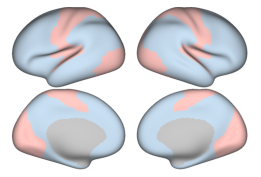

In [4]:
mask = np.zeros((360,))
for net in sensorimotornets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    mask[net_ind] = 1
for net in associationnets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    mask[net_ind] = 2

    
if not os.path.exists(figuredir + 'UnimodalTransmodalMask.png'):
    tmp = np.hstack((mask[180:],mask[:180]))
    wbplot.pscalar(figuredir + 'UnimodalTransmodalMask.png',tmp,vrange=(1,8),cmap='Pastel1')
    # wbplot.pscalar(figuredir + 'UnimodalTransmodalMask.png',tmp,vrange=(1,8),cmap=[color1,color2])

plt.figure(figsize=(5,3))
im = img.imread(figuredir + 'UnimodalTransmodalMask.png') 
plt.imshow(im);
plt.axis('off');
plt.savefig(figuredir + 'UnimodalTransmodalMask_Fig.png')

# Load group FC matrix

In [8]:
groupfc = np.loadtxt('../processed_data/groupfc.txt')

# Load & Plot in inter-region RSMs

Similarity of regional RSMs and resting-state FC SpearmanrResult(correlation=0.3677564747181448, pvalue=0.0)


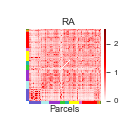

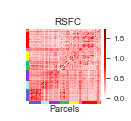

In [10]:
distance = 'cosine'
rsm_matrix = 'cosine'
rep_dist_mat_unthresh = np.loadtxt('../processed_data/analysis1/analysis1_cosine_interregion_representational_distances_cosineRSMs_unthresholded.csv')

## plt.subplot(122)
sorted_mat = np.arctanh(rep_dist_mat_unthresh[indsort,indsort.T])
ax = sns.clustermap(data=sorted_mat,
                    row_cluster=False,col_cluster=False,
                    row_colors=np.squeeze(np.asarray(parcel_network_palette)[indsort]),col_colors=np.squeeze(np.asarray(parcel_network_palette)[indsort]),
                    xticklabels=False,yticklabels=False,
                    figsize=(1.6,1.6),center=0,cmap='seismic')
ax.ax_heatmap.invert_yaxis()
# ax.ax_col_colors.invert_yaxis()
ax.ax_row_colors.invert_yaxis()
ax_col_colors = ax.ax_col_colors
box = ax_col_colors.get_position()
box_heatmap = ax.ax_heatmap.get_position()
ax_col_colors.set_position([box_heatmap.min[0], box_heatmap.y0-box.height, box.width, box.height])
# ax.cax.set_ylabel('$z$', fontsize=8,rotation=0);
ax.ax_cbar.set_position([box_heatmap.max[0] + box.height, box_heatmap.y0, box.height, box_heatmap.height])
ax.cax.tick_params(labelsize=8)
ax.fig.suptitle('RA', x=0.62, y=box_heatmap.y1+.1,fontsize=10)
ax_heatmap = ax.ax_heatmap
ax_heatmap.set_xlabel('Parcels',fontsize=9)
ax.savefig(figuredir + 'Interregion_RDM_similarity_unthresholded.pdf',transparent=True)


# plt.subplot(122)
sorted_mat = groupfc[indsort,indsort.T]
ax = sns.clustermap(data=sorted_mat,
                    row_cluster=False,col_cluster=False,
                    row_colors=np.squeeze(np.asarray(parcel_network_palette)[indsort]),col_colors=np.squeeze(np.asarray(parcel_network_palette)[indsort]),
                    xticklabels=False,yticklabels=False,
                    figsize=(1.6,1.6),center=0,cmap='seismic')
ax.ax_heatmap.invert_yaxis()
# ax.ax_col_colors.invert_yaxis()
ax.ax_row_colors.invert_yaxis()
ax_col_colors = ax.ax_col_colors
box = ax_col_colors.get_position()
box_heatmap = ax.ax_heatmap.get_position()
ax_col_colors.set_position([box_heatmap.min[0], box_heatmap.y0-box.height, box.width, box.height])
ax.cax.tick_params(labelsize=8)
ax.ax_cbar.set_position([box_heatmap.max[0] + box.height, box_heatmap.y0, box.height, box_heatmap.height])
ax.fig.suptitle('RSFC', x=0.62, y=box_heatmap.y1+0.1,fontsize=10)
ax_heatmap = ax.ax_heatmap
ax_heatmap.set_xlabel('Parcels',fontsize=9)
ax.savefig(figuredir + 'RSFC_Group.pdf',transparent=True)


triu_ind = np.triu_indices(360,k=1)
print('Similarity of regional RSMs and resting-state FC',stats.spearmanr(groupfc[triu_ind],rep_dist_mat_unthresh[triu_ind]))

# Load subject-level RSM matrices, and compute representational alignment matrix

In [11]:
h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()

nParcels = rsms_subj.shape[0]
nSubjs = rsms_subj.shape[1]
nCond = rsms_subj.shape[2]
triu_ind = np.triu_indices(nCond,k=0)
ir_rsm_subjs = np.zeros((nParcels,nParcels,len(subIDs)))
scount = 0
for subj in subIDs:

    for i in range(nParcels):
        for j in range(nParcels):
            if j>i:
                ir_rsm_subjs[i,j,scount] = np.corrcoef(rsms_subj[i,scount][triu_ind],rsms_subj[j,scount][triu_ind])[0,1]
            else:
                continue

    ir_rsm_subjs[:,:,scount] = ir_rsm_subjs[:,:,scount] + ir_rsm_subjs[:,:,scount].T
    np.fill_diagonal(ir_rsm_subjs[:,:,scount],0)
    ir_rsm_subjs[:,:,scount] = np.arctanh(ir_rsm_subjs[:,:,scount])
    scount += 1



# Compute representational segregation for RSFC and RA

In [14]:
df_assocVsensorimotor = {}
df_assocVsensorimotor['Network'] = []
df_assocVsensorimotor['Segregation'] = []
df_assocVsensorimotor['Type'] = []
df_assocVsensorimotor['ROI'] = []

mat = np.mean(ir_rsm_subjs,axis=2)
matfc = groupfc
np.fill_diagonal(mat,0)
np.fill_diagonal(matfc,0)
for net in sensorimotornets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    out_ind = np.where(networkdef!=networkmappings[net])[0]
    for roi in net_ind:
        net_ind.shape = (len(net_ind),1)
        out_ind.shape = (len(out_ind),1)
        btwn_fc = np.nanmean(mat[roi,out_ind.T])
        wthn_fc = np.nanmean(mat[roi,net_ind.T])
        segregation = (wthn_fc-btwn_fc)/wthn_fc
        df_assocVsensorimotor['Network'].append('Unimodal')
        df_assocVsensorimotor['Segregation'].append(np.mean(segregation))
        df_assocVsensorimotor['Type'].append('RA')
        df_assocVsensorimotor['ROI'].append(roi)
        # RSFC
        btwn_fc = np.nanmean(matfc[roi,out_ind.T])
        wthn_fc = np.nanmean(matfc[roi,net_ind.T])
        segregationfc = (wthn_fc-btwn_fc)/wthn_fc
        df_assocVsensorimotor['Network'].append('Unimodal')
        df_assocVsensorimotor['Segregation'].append(np.mean(segregationfc))
        df_assocVsensorimotor['Type'].append('RSFC')
        df_assocVsensorimotor['ROI'].append(roi)

mat = np.mean(ir_rsm_subjs,axis=2)
matfc = groupfc
np.fill_diagonal(mat,0)
np.fill_diagonal(matfc,0)
for net in associationnets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    out_ind = np.where(networkdef!=networkmappings[net])[0]
    for roi in net_ind:
        net_ind.shape = (len(net_ind),1)
        out_ind.shape = (len(out_ind),1)
        btwn_fc = np.nanmean(mat[roi,out_ind.T])
        wthn_fc = np.nanmean(mat[roi,net_ind.T])
        segregation = (wthn_fc-btwn_fc)/wthn_fc
        df_assocVsensorimotor['Network'].append('Transmodal')
        df_assocVsensorimotor['Segregation'].append(np.mean(segregation))
        df_assocVsensorimotor['Type'].append('RA')
        df_assocVsensorimotor['ROI'].append(roi)
        # RSFC
        btwn_fc = np.nanmean(matfc[roi,out_ind.T])
        wthn_fc = np.nanmean(matfc[roi,net_ind.T])
        segregationfc = (wthn_fc-btwn_fc)/wthn_fc
        df_assocVsensorimotor['Network'].append('Transmodal')
        df_assocVsensorimotor['Segregation'].append(np.mean(segregationfc))
        df_assocVsensorimotor['Type'].append('RSFC')
        df_assocVsensorimotor['ROI'].append(roi)
        
# df_seg = pd.DataFrame(df_seg)
df_assocVsensorimotor = pd.DataFrame(df_assocVsensorimotor)


RA v. RSFC, Unimodal: t = 3.334664645707732 | p= 0.0009980504294334741
RA v. RSFC, Transmodal: t = -4.238625627236127 | p= 2.68819308121488e-05
RA v. RSFC, All: t = -1.2361319291154755 | p= 0.21681376250083276
RA Unimodal v. RA Transmodal: t = 12.991235720702559 | p= 6.980796212827236e-32


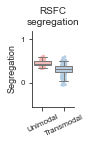

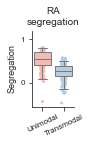

In [15]:

tmpdf = df_assocVsensorimotor.loc[df_assocVsensorimotor.Type=='RSFC']
plt.figure(figsize=(1.4,2.1))
sns.stripplot(x="Network",y="Segregation",data=tmpdf,dodge=True,size=3,palette=[color2,color1],zorder=0)
ax = sns.boxplot(x="Network",y="Segregation",data=tmpdf,sym='',whis=[2.5,97.5],palette=[color2,color1],linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None)
plt.ylabel('Segregation',fontsize=9);
plt.yticks(fontsize=8)
plt.ylim([-0.55,1.2])
sns.despine()
plt.title('RSFC\nsegregation',fontsize=10)
plt.tight_layout()
plt.savefig('../figures/SFig2/RSFCSegregation.pdf',transparent=True)

tmpdf = df_assocVsensorimotor.loc[df_assocVsensorimotor.Type=='RA']
plt.figure(figsize=(1.4,2.1))
sns.stripplot(x="Network",y="Segregation",data=tmpdf,dodge=True,size=3,palette=[color2,color1],zorder=0)
ax = sns.boxplot(x="Network",y="Segregation",data=tmpdf,sym='',whis=[2.5,97.5],palette=[color2,color1],linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=25,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None)
plt.ylabel('Segregation',fontsize=9);
plt.yticks(fontsize=8)
plt.ylim([-0.55,1.2])
plt.title('RA\nsegregation',fontsize=10)
# plt.title('Representational\nsegregation', fontsize=10);
# handles, labels = ax.get_legend_handles_labels()
# l = plt.legend(handles[:2], labels[:2], loc=3, borderaxespad=0.2, prop={'size': 6})
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig2/RAsegregation.pdf',transparent=True)




tmpdf = df_assocVsensorimotor.loc[df_assocVsensorimotor.Network=='Unimodal']
restfc = tmpdf.loc[tmpdf.Type=='RSFC']
ra = tmpdf.loc[tmpdf.Type=='RA']
t, p = stats.ttest_ind(ra.Segregation.values,restfc.Segregation.values)
print('RA v. RSFC, Unimodal: t =', t, '| p=', p)

tmpdf = df_assocVsensorimotor.loc[df_assocVsensorimotor.Network=='Transmodal']
restfc = tmpdf.loc[tmpdf.Type=='RSFC']
ra = tmpdf.loc[tmpdf.Type=='RA']
t, p = stats.ttest_ind(ra.Segregation.values,restfc.Segregation.values)
print('RA v. RSFC, Transmodal: t =', t, '| p=', p)

#### Control, compute RA v RSFC across whole brain
restfc = df_assocVsensorimotor.loc[df_assocVsensorimotor.Type=='RSFC']
ra = df_assocVsensorimotor.loc[df_assocVsensorimotor.Type=='RA']
t, p = stats.ttest_ind(ra.Segregation.values,restfc.Segregation.values)
print('RA v. RSFC, All: t =', t, '| p=', p)

#### Control, compute Trans v Unimodal for RA only
ra = df_assocVsensorimotor.loc[df_assocVsensorimotor.Type=='RA']
tmpdf_trans = ra.loc[ra.Network=='Transmodal']
tmpdf_uni = ra.loc[ra.Network=='Unimodal']
t, p = stats.ttest_ind(tmpdf_uni.Segregation.values,tmpdf_trans.Segregation.values)
print('RA Unimodal v. RA Transmodal: t =', t, '| p=', p)


# Compute difference of RA vs RSFC for trans and unimodal regions

Uni vs transmodal t = 6.317174576889676 | p= 7.907870799352765e-10


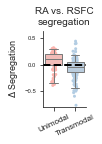

In [17]:
df_assocVsensorimotor = {}
df_assocVsensorimotor['Network'] = []
df_assocVsensorimotor['Segregation'] = []
df_assocVsensorimotor['ROI'] = []



mat = np.mean(ir_rsm_subjs,axis=2)
matfc = groupfc
np.fill_diagonal(mat,0)
np.fill_diagonal(matfc,0)
for net in sensorimotornets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    out_ind = np.where(networkdef!=networkmappings[net])[0]
    for roi in net_ind:
        net_ind.shape = (len(net_ind),1)
        out_ind.shape = (len(out_ind),1)
        btwn_fc = np.nanmean(mat[roi,out_ind.T])
        wthn_fc = np.nanmean(mat[roi,net_ind.T])
        segregation = (wthn_fc-btwn_fc)/wthn_fc
        # RSFC
        btwn_fc = np.nanmean(matfc[roi,out_ind.T])
        wthn_fc = np.nanmean(matfc[roi,net_ind.T])
        segregationfc = (wthn_fc-btwn_fc)/wthn_fc
        df_assocVsensorimotor['Network'].append('Unimodal')
        df_assocVsensorimotor['Segregation'].append(np.mean(segregation - segregationfc))
        df_assocVsensorimotor['ROI'].append(roi)

mat = np.mean(ir_rsm_subjs,axis=2)
matfc = groupfc
np.fill_diagonal(mat,0)
np.fill_diagonal(matfc,0)
for net in associationnets:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    out_ind = np.where(networkdef!=networkmappings[net])[0]
    for roi in net_ind:
        net_ind.shape = (len(net_ind),1)
        out_ind.shape = (len(out_ind),1)
        btwn_fc = np.nanmean(mat[roi,out_ind.T])
        wthn_fc = np.nanmean(mat[roi,net_ind.T])
        segregation = (wthn_fc-btwn_fc)/wthn_fc
        # RSFC
        btwn_fc = np.nanmean(matfc[roi,out_ind.T])
        wthn_fc = np.nanmean(matfc[roi,net_ind.T])
        segregationfc = (wthn_fc-btwn_fc)/wthn_fc
        df_assocVsensorimotor['Network'].append('Transmodal')
        df_assocVsensorimotor['Segregation'].append(np.mean(segregation - segregationfc))
        df_assocVsensorimotor['ROI'].append(roi)
        
# df_seg = pd.DataFrame(df_seg)
df_assocVsensorimotor = pd.DataFrame(df_assocVsensorimotor)


# tmpdf = df_assocVsensorimotor.loc[df_assocVsensorimotor.Network=='Transmodal']
plt.figure(figsize=(1.4,2.1))
ax = sns.stripplot(x="Network",y="Segregation",data=df_assocVsensorimotor, dodge=True,size=3,palette=[color2,color1],zorder=0)
sns.boxplot(x="Network",y="Segregation",data=df_assocVsensorimotor,sym='',whis=[2.5,97.5],palette=[color2,color1],linewidth=1)
plt.plot(np.arange(-0.5,2.5),np.repeat(0,3),'k',linestyle='--',linewidth=2,zorder=2)
# ax.set_xticks(fontsize=8)
plt.xticks(fontsize=8, rotation=25)
plt.yticks(fontsize=6)
# plt.yticks([])
plt.xlabel(None)
plt.ylabel('$\Delta$ Segregation',fontsize=9);
plt.ylim([-0.8,0.65])
plt.title('RA vs. RSFC\nsegregation',fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig2/RepDeltaSegregation_RAvRSFC.pdf',transparent=True)


unimodal = df_assocVsensorimotor.loc[df_assocVsensorimotor.Network=='Unimodal']
transmodal = df_assocVsensorimotor.loc[df_assocVsensorimotor.Network=='Transmodal']
t, p = stats.ttest_ind(unimodal.Segregation.values,transmodal.Segregation.values)
print('Uni vs transmodal t =', t, '| p=', p)

#### Plot segregation for each region separately

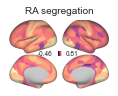

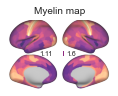

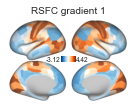

In [20]:
ir_rsm_group = np.mean(ir_rsm_subjs,axis=2)
region_seg = np.zeros((360,))
for region in range(nParcels):
    mat = ir_rsm_group
    net_ind = np.where(networkdef==networkdef[region])[0]
    out_ind = np.where(networkdef!=networkdef[region])[0]
    net_ind.shape = (len(net_ind),1)
    out_ind.shape = (len(out_ind),1)
    
    btwn_fc = np.mean(mat[region,out_ind.T])
    wthn_fc = np.mean(mat[region,net_ind.T])
    region_seg[region] = (wthn_fc-btwn_fc)/wthn_fc
np.savetxt('../processed_data/ra_segregation.txt',region_seg)
    
vrange = 2
if not os.path.exists(figuredir + 'RegionalRASegregation.png'):
    tmp = np.hstack((region_seg[180:],region_seg[:180]))
#     tmp = stats.zscore(tmp)
    vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar(figuredir + 'RegionalRASegregation.png',tmp,vrange=(-vrange,vrange),cmap='magma',transparent=True)


plt.figure(figsize=(1.75,1.5))
ax = plt.subplot(111)
im = img.imread(figuredir + 'RegionalRASegregation.png') 
plt.imshow(im)
plt.axis('off')
plt.title('RA segregation',fontsize=10)
vmin, vmax = np.min(region_seg[:]), np.max(region_seg[:])
# vmin, vmax = -2, 2
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=6.5,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=6.5,fontname='Arial');
plt.tight_layout()
plt.savefig(figuredir + 'RegionalRAegregation_Fig.png',dpi=300,transparent=True) 


#### Load myelin map
myelin_map_64k = np.loadtxt('../processed_data/MyelinMapParcellated_v1.csv',delimiter=',')
myelin_map = np.zeros((nParcels,))
for roi in range(nParcels):
    roi_ind = np.where(glasser==roi+1)[0]
    myelin_map[roi] = np.mean(myelin_map_64k[roi_ind])
#
parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')
stats.spearmanr(myelin_map,region_seg)
#
#### Plot myelin map
if not os.path.exists(figuredir + 'Parcellated_MyelinMap.png'):
    tmp = np.hstack((myelin_map[180:],myelin_map[:180]))
    tmp = stats.zscore(tmp)
    vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar(figuredir + 'Parcellated_MyelinMap.png',tmp,vrange=(-vrange,vrange),cmap='magma',transparent=True)
    
plt.figure(figsize=(1.75,1.5))
ax = plt.subplot(1,1,1)
im = img.imread(figuredir + 'Parcellated_MyelinMap.png') 
plt.imshow(im)
plt.axis('off')
plt.title('Myelin map',fontsize=10,fontname='Arial')
#
vmin, vmax = np.min(myelin_map), np.max(myelin_map)
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = plt.get_cmap('magma')
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.025, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
cax.text(1.025, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=7,fontname='Arial');
#
plt.tight_layout()
plt.savefig(figuredir + 'Parcellated_MyelinMap_Fig.png',dpi=300,transparent=True) 


##### Load RSFC Gradient 1
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
top = cm.get_cmap('Oranges_r', 128)
bottom = cm.get_cmap('Blues', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 128)),
                       bottom(np.linspace(0, 1, 128))))
# ListedColormap(colormap.colors[::-1])

newcmp = ListedColormap(newcolors[::-1], name='OrangeBlue')

parcellated_gradients = np.loadtxt('../processed_data/analysis1/analysis1_restFC_gradients.csv')
i = 0
if not os.path.exists(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '.png'):
    tmp = np.hstack((parcellated_gradients[180:,i],parcellated_gradients[:180,i]))
    vrange = np.max([np.abs(np.min(tmp)),np.max(tmp)])
    wbplot.pscalar(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '.png',tmp,vrange=(-vrange, vrange),cmap=newcmp)


plt.figure(figsize=(2,1.75))
ax = plt.subplot(111)
im = img.imread(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '.png') 
#     im = img.imread(figuredir + 'Parcellated_TaskDimensionality_' + rsm_matrix + '.png') 
plt.imshow(im)
plt.axis('off')
#
vmin, vmax = np.min(parcellated_gradients[:,i]), np.max(parcellated_gradients[:,i])
cnorm = clrs.Normalize(vmin=vmin, vmax=vmax)  # only important for tick placing
cmap = newcmp
cax = ax.inset_axes([0.44, 0.48, 0.12, 0.07])
cbar = colorbar.ColorbarBase(
    cax, cmap=cmap, norm=cnorm, orientation='horizontal')
cbar.set_ticks([-2, 2])  # don't need to do this since we're going to hide them
cax.get_xaxis().set_tick_params(length=0, pad=-2)
cbar.set_ticklabels([])
cbar.outline.set_visible(False)
cax.text(-0.04, 0.4, str(round(vmin,2)), ha='right', va='center', transform=cax.transAxes,
         fontsize=6.5,fontname='Arial');
cax.text(1.04, 0.4, str(round(vmax,2)), ha='left', va='center', transform=cax.transAxes,
         fontsize=6.5,fontname='Arial');
#
plt.imshow(im)
plt.axis('off')
plt.title('RSFC gradient 1',fontsize=10)
plt.tight_layout()
plt.savefig(figuredir + 'Parcellated_MDTB_RestGradient' + str(i+1) + '_cmap.png',dpi=300, transparent=True)

# Plot myelin map X segregation

Correlation RA Seg with myelin map 0.36386556459639763 | p = 1.03643539739473e-12
Correlation RA Seg with RSFC grad 1 0.39358819602580003 | p = 8.68520476845831e-15


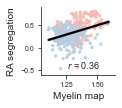

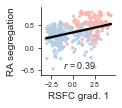

In [21]:
plt.figure(figsize=(1.8,1.6))
plt.subplot(111)
# sns.regplot(x=myelin_map,y=avg_dim,color='k',fit_reg=False)
sns.regplot(x=myelin_map,y=region_seg,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('RA segregation',fontsize=10)
plt.xlabel('Myelin map',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([1.05,1.65])
plt.ylim([-0.6,0.9])
r, p = stats.pearsonr(myelin_map,region_seg)
print('Correlation RA Seg with myelin map', r, '| p =', p)
r = round(r,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(r),
             xy=(0.35,.1),fontsize=9,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig2/ScatterPlot_SegregationXMyelin.pdf',transparent=True)


plt.figure(figsize=(1.8,1.6))
plt.subplot(111)
# sns.regplot(x=myelin_map,y=avg_dim,color='k',fit_reg=False)
sns.regplot(x=parcellated_gradients[:,0],y=region_seg,color='k',scatter_kws={'s':6,'color':roiColorsByNetwork})
plt.ylabel('RA segregation',fontsize=10)
plt.xlabel('RSFC grad. 1',fontsize=10)
# plt.title('',fontsize=30)
plt.xticks(fontsize=7)
plt.yticks(fontsize=7)
plt.xlim([-3.7,4.9])
plt.ylim([-0.6,0.9])
r, p = stats.pearsonr(parcellated_gradients[:,0],region_seg)
print('Correlation RA Seg with RSFC grad 1', r, '| p =', p)
r = round(r,2)
p = round(p,2)
plt.annotate(r'$r$'+ ' = ' + str(r),
             xy=(0.3,.1),fontsize=9,xycoords='axes fraction')
plt.tight_layout()
sns.despine()
plt.savefig(figuredir + 'ScatterPlot_SegregationXRSFC1.pdf',transparent=True)



# Brain smash multi-task decoding and rep dim

In [17]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)
n_surrogates = 1000
geo_dist_rh = np.loadtxt('../processed_data/RightParcelGeodesicDistmat.txt')
geo_dist_lh = np.loadtxt('../processed_data/LeftParcelGeodesicDistmat.txt')
base = Base(region_seg[:180],geo_dist_lh)
surrogates_lh = base(n=n_surrogates)
base = Base(region_seg[180:],geo_dist_rh)
surrogates_rh = base(n=n_surrogates)
surrogates_seg = np.hstack((surrogates_lh,surrogates_rh))

In [24]:
surrogate_brainmap_corrs = pearsonr(surrogates_seg,myelin_map).flatten()
test_stat = stats.pearsonr(region_seg,myelin_map)[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between RA seg and myelin map: r =', r, '| p =', p)

surrogate_brainmap_corrs = pearsonr(surrogates_seg,parcellated_gradients[:,0]).flatten()
test_stat = stats.pearsonr(region_seg,parcellated_gradients[:,0])[0]
pval = nonparp(test_stat, surrogate_brainmap_corrs)
r, p = test_stat, pval
print('Correlation between RA seg and RSFC Grad 1: r =', r, '| p =', p)

Correlation between RA seg and myelin map: r = 0.36386556459639774 | p = 0.0
Correlation between RA seg and RSFC Grad 1: r = 0.3935881960258002 | p = 0.0


/var/folders/j_/sqyl0rss2cj2rbvf8gs3q1nh5b6ztc/T/ipykernel_89899/799476349.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(rect=[0, 0, .9, 1])


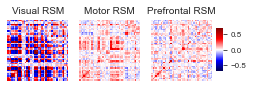

In [22]:
h5f = h5py.File('../processed_data/analysis1/analysis1_regional_rdms_cosine_allsubjs.h5','r')
rsms_subj = h5f['data'][:].copy()

thresh = 1.0
rsms_group = np.mean(rsms_subj,axis=1)

roi_min_fpn = 72
roi_max_mot = 7
roi_max_vis = 19

#### This is if you want to visualize these ROIs on the surface
# example_64k = np.zeros((len(glasser),))
# i = 5
# for roi in [roi_max_vis, roi_min_fpn, roi_max_mot]:
#     roi_ind = np.where(glasser==roi+1)[0]
#     example_64k[roi_ind] = i
#     i += 1

# filename = 'VisMotorFpnExampleRegions'
# np.savetxt(figuredir + filename + '.csv',example_64k,fmt='%s')
# wb_file = filename + '.dscalar.nii'
# wb_command = 'wb_command -cifti-convert -from-text ' + figuredir + filename + '.csv ' + glasserfilename + ' ' + figuredir + wb_file + ' -reset-scalars'
# os.system(wb_command)

fig, axn = plt.subplots(1, 3, sharex=True, sharey=True,figsize=(3.5,1.5))
cbar_ax = fig.add_axes([.87, .3, .03, .4])

regions = [roi_max_vis, roi_max_mot, roi_min_fpn]
titles = ['Visual RSM', 'Motor RSM', 'Prefrontal RSM']
for i, ax in enumerate(axn.flat):
    sns.heatmap(rsms_group[regions[i]], center=0, square=True, cmap='seismic',
                ax=ax,
                cbar=i == 0,
                vmin=-0.7, vmax=0.7,
                cbar_ax=None if i else cbar_ax)
    ax.invert_yaxis();
    ax.set_xticks([]);
    ax.set_yticks([]);
    ax.set_title(titles[i],fontsize=10)
cbar_ax.tick_params(labelsize=8)
# fig.tight_layout()
fig.tight_layout(rect=[0, 0, .9, 1])
fig.savefig(figuredir + 'VisMotorFPN_ExampleRSMs.pdf',transparent=True)


# Plot a force directed graph comparing RA to FC

In [23]:
import networkx
thresh = 0.02


tmpfc = bct.threshold_proportional(groupfc,thresh)
fcnodesize = np.mean(tmpfc,axis=1)
G_fc = nx.Graph(tmpfc)

tmprsm = bct.threshold_proportional(rep_dist_mat_unthresh,thresh)
rsmnodesize = np.mean(tmprsm,axis=1)
G_rsm = nx.Graph(tmprsm)

posfc = networkx.layout.kamada_kawai_layout(G_fc)
posrsm = networkx.layout.kamada_kawai_layout(G_rsm)



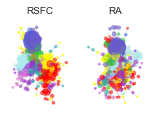

In [24]:
plt.figure(figsize=(2.25,1.75))

plt.subplot(121)
nx.draw_networkx(G_fc, with_labels=False,
                 node_color=parcel_network_palette, 
                 alpha=0.5, 
                 width=0.2,
                 node_size=fcnodesize*1500,
                 pos=posfc,
                 arrowstyle='fancy')
plt.axis('off');
plt.title('RSFC',fontsize=10, fontname='Arial')

plt.subplot(122)
nx.draw_networkx(G_rsm, with_labels=False,
                 node_color=parcel_network_palette, 
                 alpha=0.5, 
                 width=0.2,
                 node_size=rsmnodesize*1500,
                 pos=posrsm,
                 arrowstyle='fancy')
plt.axis('off');
plt.tight_layout()
plt.title('RA',fontsize=10, fontname='Arial')
plt.savefig('../figures/SFig2/GraphViz_FC_RA.pdf',transparent=True)


____

# Supplementary panels


# Compute representational segregation for RSFC and RA by functional network

In [26]:
df_net = {}
df_net['Network'] = []
df_net['Segregation'] = []
df_net['Type'] = []
df_net['ROI'] = []



mat = np.mean(ir_rsm_subjs,axis=2)
matfc = groupfc
np.fill_diagonal(mat,0)
np.fill_diagonal(matfc,0)
i = 0
for net in orderednetworks:
    net_ind = np.where(networkdef==networkmappings[net])[0]
    out_ind = np.where(networkdef!=networkmappings[net])[0]
    for roi in net_ind:
        net_ind.shape = (len(net_ind),1)
        out_ind.shape = (len(out_ind),1)
        btwn_fc = np.nanmean(mat[roi,out_ind.T])
        wthn_fc = np.nanmean(mat[roi,net_ind.T])
        segregation = (wthn_fc-btwn_fc)/wthn_fc
        df_net['Network'].append(OrderedNetworks[i])
        df_net['Segregation'].append(np.mean(segregation))
        df_net['Type'].append('RA')
        df_net['ROI'].append(roi)
        # RSFC
        btwn_fc = np.nanmean(matfc[roi,out_ind.T])
        wthn_fc = np.nanmean(matfc[roi,net_ind.T])
        segregationfc = (wthn_fc-btwn_fc)/wthn_fc
        df_net['Network'].append(OrderedNetworks[i])
        df_net['Segregation'].append(np.mean(segregationfc))
        df_net['Type'].append('RSFC')
        df_net['ROI'].append(roi)
    i += 1

df_net = pd.DataFrame(df_net)


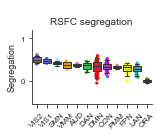

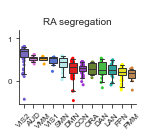

In [27]:


tmpdf = df_net.loc[df_net.Type=='RSFC']
# Sort from high to low
tmpvalues = tmpdf.groupby("Network").mean()
tmpvalues = tmpvalues.sort_values(by="Segregation",ascending=False)
order = []
for i in tmpvalues.index: order.append(np.where(np.asarray(OrderedNetworks)==i)[0][0])
order = np.asarray(order)
#
plt.figure(figsize=(2.5,2))
sns.stripplot(x="Network",y="Segregation", order=np.asarray(OrderedNetworks)[order],data=tmpdf,dodge=True,size=3,palette=networkpalette[order],zorder=0)
ax = sns.boxplot(x="Network",y="Segregation",order=np.asarray(OrderedNetworks)[order], data=tmpdf,sym='',whis=[2.5,97.5],palette=networkpalette[order],linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=45,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None)
plt.ylabel('Segregation',fontsize=9);
plt.yticks(fontsize=8)
plt.ylim([-0.55,1.2])
plt.title('\nRSFC segregation',fontsize=10)
plt.tight_layout()
sns.despine()
plt.savefig('../figures/SFig2/RSFCSegregation_byNetwork.pdf',transparent=True)

tmpdf = df_net.loc[df_net.Type=='RA']
# Sort from high to low
tmpvalues = tmpdf.groupby("Network").mean()
tmpvalues = tmpvalues.sort_values(by="Segregation",ascending=False)
order = []
for i in tmpvalues.index: order.append(np.where(np.asarray(OrderedNetworks)==i)[0][0])
order = np.asarray(order)
plt.figure(figsize=(2.3,2))
sns.stripplot(x="Network",y="Segregation", order=np.asarray(OrderedNetworks)[order],data=tmpdf,dodge=True,size=3,palette=networkpalette[order],zorder=0)
ax = sns.boxplot(x="Network",y="Segregation",order=np.asarray(OrderedNetworks)[order], data=tmpdf,sym='',whis=[2.5,97.5],palette=networkpalette[order],linewidth=1.0) #,order=hierarchy_ind,palette=networkpalette)
plt.xticks(rotation=45,fontsize=8)
# plt.xlabel('Network',fontsize=10);
plt.xlabel(None)
plt.ylabel(None)
# plt.ylabel('Segregation',fontsize=9);
plt.yticks(fontsize=8)
plt.ylim([-0.55,1.2])
plt.title('\nRA segregation',fontsize=10)
sns.despine()
plt.tight_layout()
plt.savefig('../figures/SFig2/RASegregation_byNetwork.pdf',transparent=True)
